In [1]:
import time

import tensorflow as tf
import tflite_runtime.interpreter as tflite

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
USE_EDGETPU = True

DEVICE = 'pci'
#DEVICE = 'usb'

if USE_EDGETPU:
    model_path = 'model_untrained_quant_edgetpu.tflite'
    interpreter = tflite.Interpreter(model_path,
      experimental_delegates=[tflite.load_delegate('libedgetpu.so.1', options={'device': DEVICE})])
else:
    model_path = 'model_quant.tflite'
    interpreter = tflite.Interpreter(model_path)
    
interpreter.allocate_tensors()

In [4]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [5]:
INPUT_SHAPE = output_details[0]['shape'][1:4]

input_details

[{'name': 'serving_default_input_3',
  'index': 10,
  'shape': array([  1, 256, 256,   3], dtype=int32),
  'shape_signature': array([  1, 256, 256,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.003921568859368563, 0),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [6]:
OUTPUT_SHAPE = output_details[0]['shape'][1:4]

output_details

[{'name': 'StatefulPartitionedCall',
  'index': 11,
  'shape': array([  1, 256, 256,   2], dtype=int32),
  'shape_signature': array([  1, 256, 256,   2], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (6.148270040284842e-05, 156),
  'quantization_parameters': {'scales': array([6.14827e-05], dtype=float32),
   'zero_points': array([156], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [7]:
import tensorflow_datasets as tfds

from data_prep import cityscapes_prep, class_map_road, labelme_prep

from utils import segmentation_to_image, display_dataset

cityscapes = tfds.load('cityscapes/semantic_segmentation')
test_ds = cityscapes['validation'].map(cityscapes_prep(OUTPUT_SHAPE, INPUT_SHAPE, class_map_road, float_range=False))

#ds = tf.data.Dataset.list_files('../paperstreet/1/*.json')
#test_ds = ds.map(labelme_prep(OUTPUT_SHAPE, float_range=False))

#test_ds = tf.data.Dataset.list_files('file.png')
#test_ds = ds.map(lambda fn: (tf.io.resize(tf.io.decode_image(tf.io.read_file(fn)), (512,1024)), tf.zeros(OUTPUT_SHAPE)))


invoke: 0.035s (28.47 fps)
invoke: 0.030s (33.90 fps)
invoke: 0.030s (33.12 fps)
invoke: 0.032s (31.51 fps)
invoke: 0.030s (33.31 fps)
invoke: 0.030s (33.04 fps)
invoke: 0.030s (33.83 fps)
invoke: 0.030s (32.87 fps)
invoke: 0.029s (34.06 fps)
invoke: 0.029s (34.02 fps)


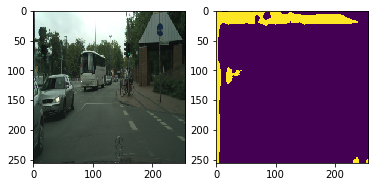

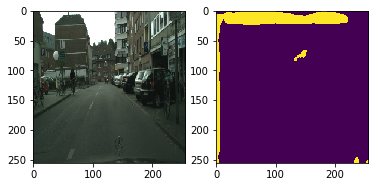

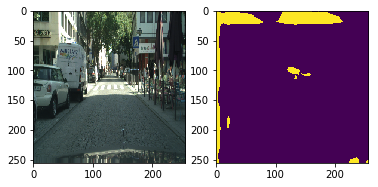

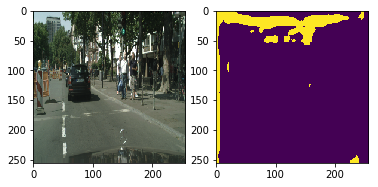

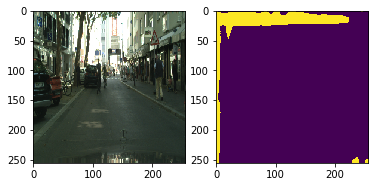

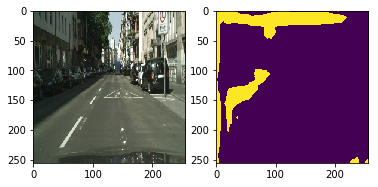

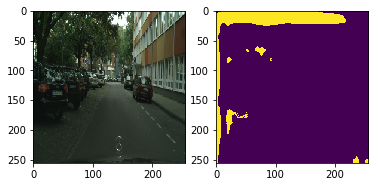

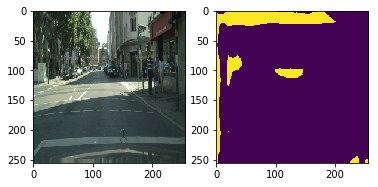

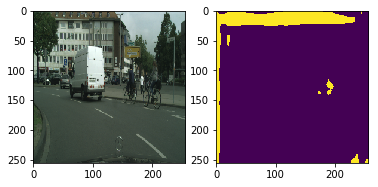

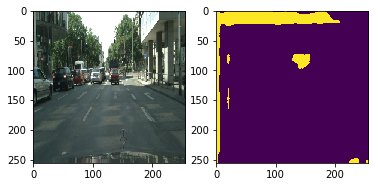

In [10]:
def pred_func(sample):
    input_data = tf.expand_dims(sample[0], axis=0)
    input_data = tf.cast(input_data, tf.dtypes.uint8)
    
    #truth_data = sample[1]
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    s = time.time()
    interpreter.invoke()
    e = time.time()
    print(f'invoke: {e-s:.3f}s ({1/(e-s):.2f} fps)')
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    return input_data[0], output_data[0]

display_dataset(test_ds.take(10), pred_func)